# Coding Challenge: Clockwise Anatomy Therapeutics
- team is building an early stage lung cancer screening service
- build a machine learning model that helps identify whether a patient has a developing adenocarcinoma (binary classification problem)
- gene expression activity

## Workflow:
- get data
- data exploration
- data cleaning
- data preprocessing (normalizing, encoding)
- baseline model --> log regression
- trying out more complex model
- hyperparameter tuning --> grid or random search
- feature engineering/selection if needed

# Coding

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Get Data

In [2]:
data = pd.read_csv('/Users/evablech/Desktop/kYNLBcWGr7xtSvWaqQ3jd19c.csv')
data.head()

,gene1,gene2,gene3,gene4,gene5,proteinA,adenocarcinoma
0,-4.253070,1060.828274,0.723866,-183.193766,899.840296,absent,0
1,-9.394422,745.845012,1.177609,-348.189944,-320.521019,absent,1
2,-12.529502,1210.943422,0.362242,447.704411,643.489025,present,0
3,-8.676414,1339.463332,0.937266,397.341232,837.099109,absent,1
4,-2.462555,-148.879229,1.509619,404.786878,-1356.039919,present,1


## data exploration

In [3]:
data.shape

(1000, 7)

In [4]:
data.isnull().sum() #gene 2 imputation or deletion?

gene1               0
gene2             177
gene3               0
gene4               0
gene5               0
proteinA            0
adenocarcinoma      0
dtype: int64

In [5]:
#target represenation
data.adenocarcinoma.value_counts() #almost twice as many rows with patient who has adenocarcinoma 
#--> need to handle unbalanced binary classification

1    656
0    344
Name: adenocarcinoma, dtype: int64

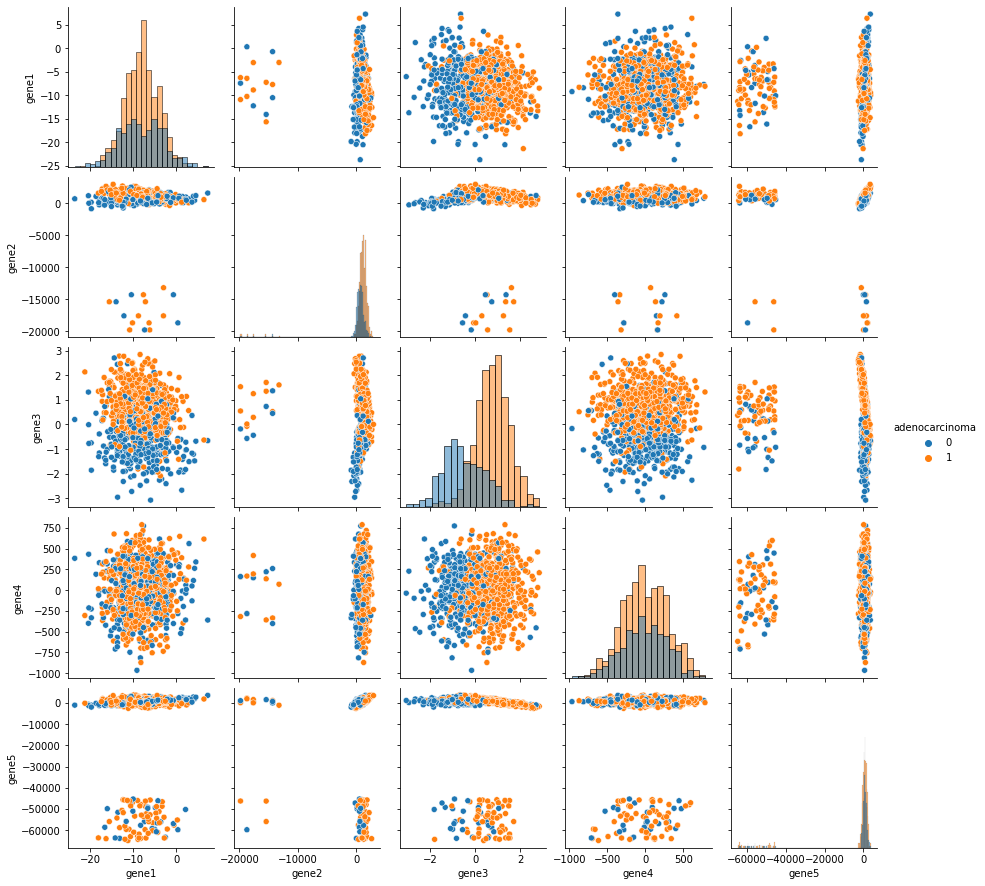

In [6]:
#exploring relationships between features with sns plot
import seaborn as sns

sns.pairplot(data, hue = 'adenocarcinoma', diag_kind = 'hist')

## Data cleaning
- impute gene2

/Users/evablech/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/evablech/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  9.,   3.,   4.,   0.,   0.,   0.,   0.,   0., 232., 575.]),
 array([-19800.        , -17521.52085668, -15243.04171335, -12964.56257003,
        -10686.08342671,  -8407.60428339,  -6129.12514006,  -3850.64599674,
         -1572.16685342,    706.31228991,   2984.79143323]),
 <BarContainer object of 10 artists>)

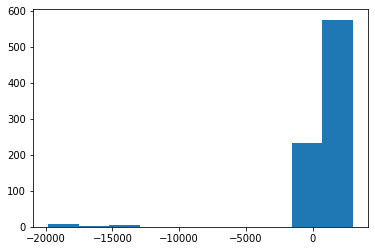

In [7]:
plt.hist(data.gene2)

gene2 contains outliers so mean is not a good imputation method, instead use median

In [8]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')
data['gene2'] = imputer.fit_transform(data[['gene2']])

## Data preprocessing
- handle unbalanced binary classification --> Using SMOTE to not loose any data
- encode protein a 

In [9]:
#encode proteinA to 0 absent, 1 present
data.proteinA = data.proteinA.map({'absent': 0, 'present':1})

In [10]:
#SMOTE over sample minority classes through Synthetic Minority Oversampling Technique
#define X and y
#is this really necessary?
X = data[['gene1', 'gene2', 'gene3', 'gene4', 'gene5', 'proteinA']]
y = data['adenocarcinoma']

In [11]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X,y)

In [13]:
y_resampled.value_counts()

1    656
0    656
Name: adenocarcinoma, dtype: int64

In [15]:
X_resampled.shape

(1312, 6)

no need for normalizing or standardizing becasue all continuous values are using the same units

## Baseline model: Logistic Regression
- cross validation
- tuning hyperparameters
- train-test split
- Performance Metric: recall, want to identify as many patients with adenocarcinoma as possible

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

penalty = ['l1', 'l2']
C = [1, 2, 5, 10, 20, 50, 100]
grid = {'penalty': penalty, 'C': C}

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=1)

model = LogisticRegression()

grid_search = GridSearchCV(model, grid, scoring = 'recall', cv = 5)

grid_search.fit(X_resampled, y_resampled)


/Users/evablech/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/evablech/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/evablech/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/evablech/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/User

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 2, 5, 10, 20, 50, 100],
                         'penalty': ['l1', 'l2']},
             scoring='recall')

In [29]:
grid_search.best_score_

0.7956974323386536

In [30]:
grid_search.best_params_

{'C': 1, 'penalty': 'l2'}

In [31]:
model = grid_search.best_estimator_

In [32]:
from sklearn.metrics import recall_score

In [33]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
recall_score(y_test, y_pred)

0.7788944723618091

## Attempt at better score with other classifiers

### KNN classifier

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
grid = {'n_neighbors': [2,5,10,20,50,100], 
        'weights': ['uniform', 'distance']}

grid_search = GridSearchCV(knn_model, grid, scoring = 'recall', cv = 5)

grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 5, 10, 20, 50, 100],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [35]:
grid_search.best_score_

0.7575526254915568

In [36]:
knn_model = grid_search.best_estimator_

In [37]:
knn_model.fit(X_train,y_train)
y_pred = knn_model.predict(X_test)
recall_score(y_test, y_pred)

0.7487437185929648

worse than baseline model.

### SVM classifier

In [27]:
from sklearn.svm import SVC

svc = SVC()
grid = {'C': [1, 2, 5, 10, 20, 50, 100], 
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid_search = GridSearchCV(svc, grid, scoring = 'recall', cv = 5)

grid_search.fit(X_resampled, y_resampled)

KeyboardInterrupt: 

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

In [ ]:
svc_model = grid_search.best_estimator_

In [ ]:
svc_model.fit(X_train,y_train)
y_pred = svc_model.predict(X_test)
recall_score(y_test, y_pred)

took too long

### Naive Bayes

In [38]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()

grid_search = GridSearchCV(nb_model, 
                           param_grid = {'var_smoothing': [0.0001, 0.001, 0.01, 0.1, 0.3]},
                           scoring = 'recall', 
                           cv = 5)
grid_search.fit(X_resampled, y_resampled)
grid_search.best_score_

0.13556557945870923

In [39]:
grid_search.best_params_

{'var_smoothing': 0.0001}

In [40]:
nb_model = grid_search.best_estimator_

In [41]:
nb_model.fit(X_train,y_train)
y_pred = nb_model.predict(X_test)
recall_score(y_test, y_pred)

0.11557788944723618

really really bad score

### Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

grid = {'n_estimators': [10, 50, 100, 200], 
        'criterion': ['gini', 'entropy'], 
        'max_features': ['auto', 'sqrt', 'log2']}

grid_search = GridSearchCV(random_forest, 
                           param_grid = grid,
                           scoring = 'recall', 
                           cv = 5)
grid_search.fit(X_resampled, y_resampled)
grid_search.best_score_

0.8993869997686792

In [54]:
grid_search.best_params_

{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 200}

In [55]:
rf_model = grid_search.best_estimator_

In [56]:
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
recall_score(y_test, y_pred)

0.8844221105527639

Significantly better than the models before. Explore more ensemble methods

### AdaBoostClassifier

In [65]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
grid = {'n_estimators': [2,5,10, 20, 50, 100, 200],
        'learning_rate': [0.001, 0.01, 0.1, 0.3]}

grid_search = GridSearchCV(adaboost, 
                           param_grid = grid,
                           scoring = 'recall', 
                           cv = 5)
grid_search.fit(X_resampled, y_resampled)
grid_search.best_score_

0.9115429100161926

In [66]:
grid_search.best_params_

{'learning_rate': 0.001, 'n_estimators': 2}

In [67]:
adaboost = grid_search.best_estimator_

In [68]:
adaboost.fit(X_train,y_train)
y_pred = adaboost.predict(X_test)
recall_score(y_test, y_pred)

0.9246231155778895

Best score so far.

## Save Model as joblib file


In [69]:
import joblib
joblib.dump(adaboost, '/Users/evablech/code/evablech/CodingChallenge/adaboost_model.joblib')

['/Users/evablech/code/evablech/CodingChallenge/adaboost_model.joblib']